In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from PIL import Image

In [2]:
DATA_PATH = "./data/"

In [3]:
def normalize_and_resize_image(image_path):
    preprocess = transforms.Compose(
        [
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

    image = Image.open(image_path)
    image = image.convert("RGB")

    input_tensor = preprocess(image)
    
    return input_tensor

In [4]:
print(normalize_and_resize_image(DATA_PATH + image))

NameError: name 'image' is not defined

In [5]:
class ArtDataset(torch.utils.data.Dataset):
    def __init__(self, num_images=2782):
        self.size = num_images
            

    def __getitem__(self, index):
        data_path = "./data/"
        image_path = f"Abstract_image_{index}.jpg"
        return (normalize_and_resize_image(data_path + image_path), 1)

    def __len__(self):
        return self.size


In [6]:
train_dataset = ArtDataset()
train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=16, shuffle=True
    )

In [7]:
for x in train_dataloader:
    print(x)
    break

[tensor([[[[-0.6965, -0.7650, -1.1247,  ..., -1.1760, -1.1760, -1.1589],
          [-0.7993, -0.9192, -1.1760,  ..., -1.1589, -1.1760, -1.1589],
          [-0.8849, -1.0219, -1.2617,  ..., -1.1932, -1.1760, -1.1589],
          ...,
          [-0.4739, -0.6109, -0.4739,  ..., -1.3644, -1.3987, -1.3987],
          [-0.2342, -0.5253, -0.3198,  ..., -1.3644, -1.3815, -1.3644],
          [-0.1999, -0.6281, -0.3027,  ..., -1.3644, -1.3815, -1.3644]],

         [[ 0.0476, -0.0224, -0.5651,  ..., -0.4776, -0.5126, -0.4776],
          [-0.0049, -0.1975, -0.6352,  ..., -0.4601, -0.4776, -0.4776],
          [-0.0924, -0.2850, -0.7402,  ..., -0.4951, -0.4776, -0.4951],
          ...,
          [-0.0049, -0.0924,  0.0301,  ..., -1.1429, -1.1779, -1.2129],
          [ 0.2227, -0.0399,  0.1877,  ..., -1.1604, -1.1779, -1.1779],
          [ 0.1527, -0.2150,  0.1702,  ..., -1.1429, -1.1779, -1.1429]],

         [[ 0.8448,  0.7751,  0.3742,  ...,  1.1934,  1.1062,  1.0539],
          [ 0.8274,  0.6356, 

In [8]:
class Discriminator(torch.nn.Module):
    def __init__(self, layer_sizes=[256, 128, 2], dropout_prob=None, device=None):
        super(Discriminator, self).__init__()
        self.device = device

        if dropout_prob is not None and dropout_prob > 0.5:
            print("Are you sure dropout_prob is supposed to be greater than 0.5?")
            
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 4, stride = 2, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.leakyRelu = nn.LeakyReLU()

        self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 4, stride = 2, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 4, stride = 2, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 4, stride = 2, padding=1)
        self.bn4 = nn.BatchNorm2d(512)

        self.conv5 = nn.Conv2d(in_channels = 512, out_channels = 1, kernel_size = 4, stride = 1)
        self.sig = nn.Sigmoid()


    def forward(self, inputs):
        x = self.leakyRelu(self.bn1(self.conv1(inputs)))
        x = self.leakyRelu(self.bn2(self.conv2(x)))
        x = self.leakyRelu(self.bn3(self.conv3(x)))
        x = self.leakyRelu(self.bn4(self.conv4(x)))
        x = self.conv5(x)
        output = self.sig(x)
        
        return output

In [20]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        nc = 3
        nz = 100
        nf = 64
        
        self.conv1 = nn.ConvTranspose2d(in_channels=nz,out_channels=nf * 8, kernel_size = 4, stride = 1, padding = 0, bias=False)
        self.bn1 = nn.BatchNorm2d(nf * 8)
        self.lr1 = nn.LeakyReLU()
        # (ngf*8) x 4 x 4

        self.conv2 = nn.ConvTranspose2d(in_channels = nf * 8, out_channels = nf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False)
        self.bn2 = nn.BatchNorm2d(nf * 4)
        self.lr2 = nn.LeakyReLU()
        # (ngf*4) x 8 x 8

        self.conv3 = nn.ConvTranspose2d(in_channels = nf * 4, out_channels = nf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False)
        self.bn3 = nn.BatchNorm2d(nf * 2)
        self.lr3 = nn.LeakyReLU()
        # (ngf*2) x 16 x 16
        
        self.conv4 = nn.ConvTranspose2d(in_channels = nf * 2, out_channels = nf, kernel_size = 4, stride = 2, padding = 1, bias=False)
        self.bn4 = nn.BatchNorm2d(nf)
        self.lr4 = nn.LeakyReLU()
        # (ngf) x 32 x 32
        
        self.conv5 = nn.ConvTranspose2d(in_channels = nf, out_channels = nc, kernel_size = 4, stride = 2, padding = 1, bias=False)
        self.tanh = nn.Tanh()
        # (nc) x 64 x 64

    def forward(self, inputs):
        x = self.lr1(self.bn1(self.conv1(inputs)))
        x = self.lr2(self.bn2(self.conv2(x)))
        x = self.lr3(self.bn3(self.conv3(x)))
        x = self.lr4(self.bn4(self.conv4(x)))
        x = self.conv5(x)
        output = self.tanh(x)
        
        return output

In [12]:
model = Discriminator()

for i, batch_data in enumerate(train_dataloader):
    print(i)
#     print(batch_data)
    x, labels = batch_data
    outputs = model.forward(x)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 64, 64])


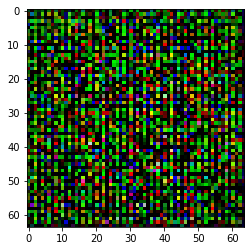

In [44]:
import matplotlib.pyplot as plt
import numpy as np

zeroes = torch.randn(1, 100, 1, 1)

gen = Generator()

output = gen.forward(zeroes)
print(output.squeeze().shape)

im = output.detach().numpy()

im = im.squeeze()
im = np.transpose(im, (1, 2, 0))

plt.imshow(im)

In [78]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")


def train(gen, dis, train_dataloader, device, num_epochs=5):
    
    optimizer_dis = optim.Adam(dis.parameters(), lr=2e-4, betas=(0.5, 0.999))
    optimizer_gen = optim.Adam(gen.parameters(), lr=2e-4, betas=(0.5, 0.999))
    
    gen_losses = []
    dis_losses = []

    for epoch in range(num_epochs):
        for i, batch_data in enumerate(train_dataloader):
            
            dis.zero_grad()
            x  = batch_data[0].to(device)
            real_labels = torch.ones(16, requires_grad=False, device=device).to(device)
            discrimator_real = dis.forward(x.detach()).squeeze()
            
            error_real = nn.BCELoss()(discrimator_real, real_labels)

            error_real.backward(retain_graph=True)

            noise = torch.randn(16, 100, 1, 1).to(device)

            fake_images = gen.forward(noise)
            fake_labels = torch.zeros(16, device=device)

            discrimator_fake = dis.forward(fake_images).squeeze()

            error_fake = nn.BCELoss()(discrimator_fake, fake_labels)

            error_fake.backward(retain_graph=True)

            optimizer_dis.step()
            gen.zero_grad()

            dis_error = error_real + error_fake
            dis_losses.append(dis_error.item())

            output = dis.forward(fake_images).squeeze()

            gen_error = nn.BCELoss()(output, real_labels)
        
            gen_losses.append(gen_error.item())

            gen_error.backward(retain_graph=True)

            optimizer_gen.step()
            
            accuracy = discrimator_real.mean().item()
            
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\t'
                  % (epoch, num_epochs, i, len(train_dataloader),
                     dis_error.item(), gen_error.item(), accuracy))
            
        
    return(gen_losses, dis_losses)

gen = Generator().to(device)
dis = Discriminator().to(device)
train(gen, dis, train_dataloader, device)


[0/5][0/174]	Loss_D: 1.4315	Loss_G: 3.9339	D(x): 0.5433	
[0/5][1/174]	Loss_D: 1.1568	Loss_G: 2.3623	D(x): 0.4645	
[0/5][2/174]	Loss_D: 1.1188	Loss_G: 3.1148	D(x): 0.6408	
[0/5][3/174]	Loss_D: 0.9567	Loss_G: 3.4087	D(x): 0.6333	
[0/5][4/174]	Loss_D: 0.8510	Loss_G: 3.5186	D(x): 0.6450	
[0/5][5/174]	Loss_D: 0.8717	Loss_G: 4.0973	D(x): 0.7000	
[0/5][6/174]	Loss_D: 0.7610	Loss_G: 3.8023	D(x): 0.6412	
[0/5][7/174]	Loss_D: 0.6877	Loss_G: 4.8782	D(x): 0.7972	
[0/5][8/174]	Loss_D: 0.7316	Loss_G: 5.1207	D(x): 0.7265	
[0/5][9/174]	Loss_D: 0.7999	Loss_G: 4.0470	D(x): 0.6067	
[0/5][10/174]	Loss_D: 0.6287	Loss_G: 6.2107	D(x): 0.8552	
[0/5][11/174]	Loss_D: 0.3099	Loss_G: 5.1473	D(x): 0.8234	
[0/5][12/174]	Loss_D: 0.6808	Loss_G: 5.9108	D(x): 0.7390	
[0/5][13/174]	Loss_D: 0.4470	Loss_G: 5.7712	D(x): 0.7844	
[0/5][14/174]	Loss_D: 0.5894	Loss_G: 6.5613	D(x): 0.7510	
[0/5][15/174]	Loss_D: 0.3427	Loss_G: 6.4528	D(x): 0.8497	
[0/5][16/174]	Loss_D: 0.3758	Loss_G: 6.8076	D(x): 0.8386	
[0/5][17/174]	Loss_D: 0.

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 64, 64])


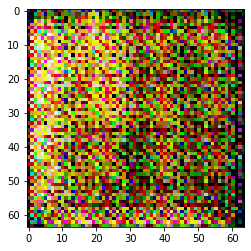

In [74]:
zeroes = torch.randn(1, 100, 1, 1)

output = gen.forward(zeroes)
print(output.squeeze().shape)

im = output.detach().numpy()

im = im.squeeze()
im = np.transpose(im, (1, 2, 0))

plt.imshow(im)